In [5]:
import pandas as pd
import seaborn as sns
import oracledb as orc
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

In [6]:
connection = orc.connect(
    user = 'tasker',
    password = 'qwerty',
    host= 'localhost',
    port = 1521,
    service_name = 'taskerpdb')

input_token_cost = 0.150/1000000

# Tasker data analysis
## Purpose
The purpose of the analysis is to show influence of additional information supplied to large language model sucha as ChatGPT to the outcome of the generation. Questions to be answered:
- When do additional documents supply become obsolete from the perspective of the model?
- Is there a significant difference between responses that got 3 and 10 documents?
- How does supplied  information influence response?

## Data
Data is generated with Claude large language model. It consists of tasks of the building maintenance company. Each task has a title, description, type, status, creation, update and due dates. Additionally, each task is aggregated with assignments and comments. Contents of the comments are generated to mimic real life interactions of the company employees. One document equals to one fully aggregated task in JSON format.


## Similarity
The first metric calculated is similarity between the query and response. Cosine similarity is used to determine cosine values of the multidimensional vectors which represent the text data and semantics of the words and meanings.

$$
līdzība(Q, R) = \cos (\theta ) = \dfrac {Q \cdot R} {\left\| Q\right\| \left\| R\right\|}
= \dfrac {\sum\limits_{n=1}^{n} Q_n R_n } {\sqrt{\sum\limits_{n=1}^{n} Q_n^2 } \sqrt{\sum\limits_{n=1}^{n} R_n^2 }}
$$

### Query and response similarity

<Axes: xlabel='Uzdevums', ylabel='Vaicājuma-Atbildes līdzība'>

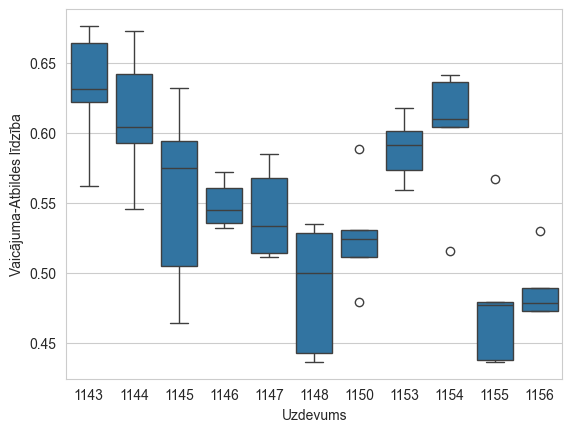

In [7]:
cursor = connection.cursor()
cursor.execute("select task_id, retrieved_task_count, input_token_count, query_response_rating from tasker.response_aggregation where task_id not in (1149, 1151, 1152)")

columns1 = ['Uzdevums', 'Izgūto uzdevumu skaits', 'Tokens used for prompt input', 'Vaicājuma-Atbildes līdzība']
df1 = pd.DataFrame(cursor.fetchall(), columns=columns1)
sns.boxplot(x='Uzdevums', y='Vaicājuma-Atbildes līdzība', data=df1)


<Axes: xlabel='Uzdevums', ylabel='Vaicājuma-Atbildes līdzība'>

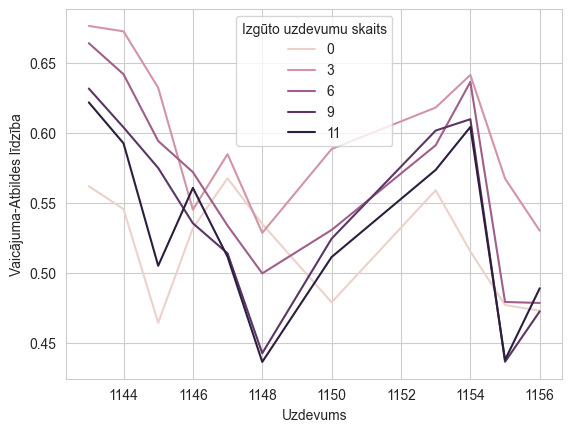

In [8]:
sns.lineplot(x='Uzdevums', y='Vaicājuma-Atbildes līdzība', hue='Izgūto uzdevumu skaits', data=df1)

<Axes: xlabel='Izgūto uzdevumu skaits', ylabel='Vaicājuma-Atbildes līdzība'>

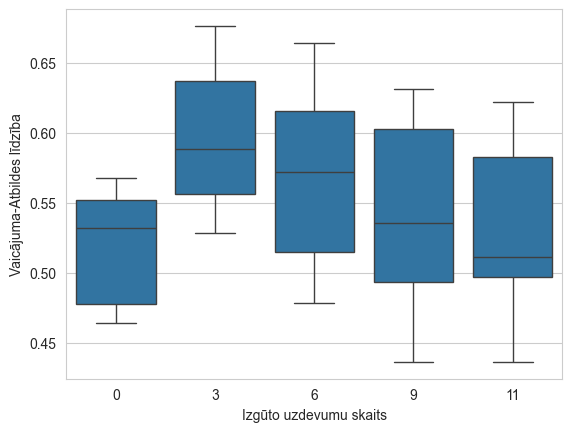

In [9]:
sns.boxplot(x='Izgūto uzdevumu skaits', y='Vaicājuma-Atbildes līdzība', data=df1)

### Task and retrieval task similarity

<Axes: xlabel='Task ID', ylabel='Task-Retrieval rating'>

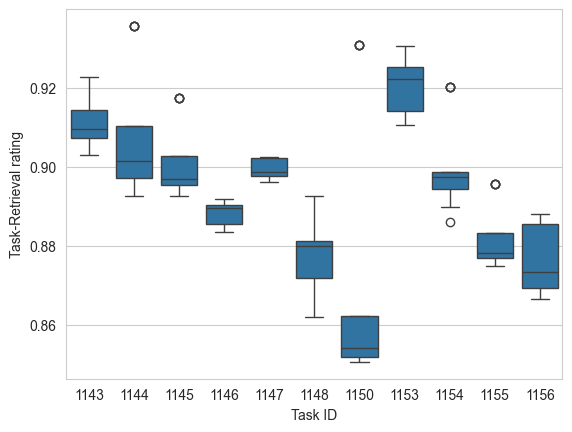

In [10]:
cursor = connection.cursor()
cursor.execute("select task_id, retrieved_task_id, rating from tasker.task_retrieval_ratings where task_id not in (1149, 1151, 1152) and rating - 1<>0")

columns1 = ['Task ID', 'Tasks used in generation', 'Task-Retrieval rating']
df2 = pd.DataFrame(cursor.fetchall(), columns=columns1)
sns.boxplot(x='Task ID', y='Task-Retrieval rating', data=df2)

## Document coverage

Document coverage could be explained as how influential aggregated tasks have been over the response. Determines whether it made any impact on the response.
$$
coverage(R, D) = C(R, D) = \dfrac {1} {N} \sum\limits_{n=1}^{N} similarity(R, D_i)
$$

<Axes: xlabel='Retrieved task count', ylabel='Response-Retrieval rating'>

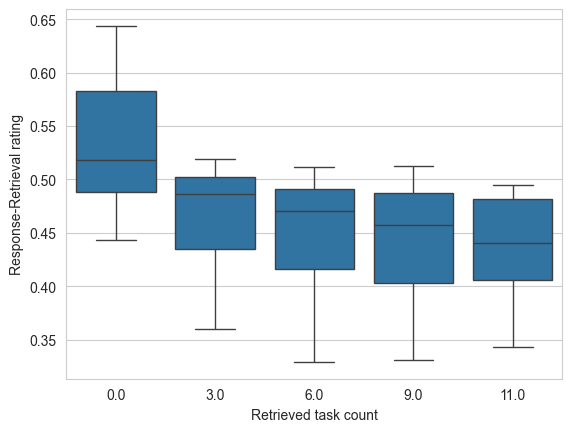

In [24]:
cursor.execute("select task_id, query_id, response_id, input_token_count, query_response_rating, retrieved_task_id, retrieved_task_count, response_retrieval_rating from tasker.query_response_retrieval_ratings where task_id not in (1149, 1151, 1152)")
columns3 = ['Task ID', 'Query ID', 'Response ID', 'Input token count', 'Query-Response rating', 'Retrieved task ID', 'Retrieved task count', 'Response-Retrieval rating']
df3 = pd.DataFrame(cursor.fetchall(), columns=columns3)
sdf31 = df3[['Response ID', 'Task ID','Input token count','Retrieved task count','Response-Retrieval rating']].groupby(['Response ID', 'Task ID'], as_index=False).mean()
sns.boxplot(x='Retrieved task count', y='Response-Retrieval rating', data=sdf31)
#print(sdf31)

<Axes: xlabel='Uzdevums', ylabel='Atbildes-Izgūtā uzdevuma līdzība'>

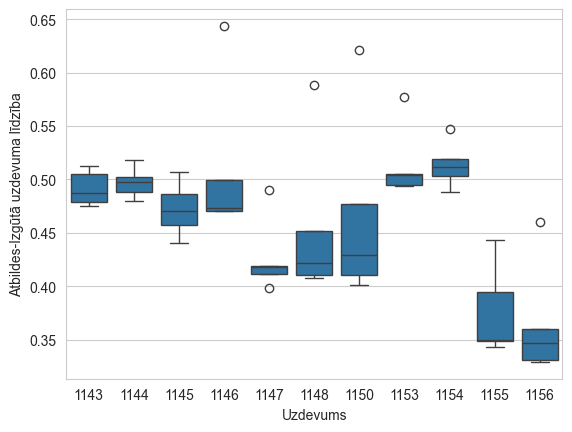

In [28]:
cursor.execute("select task_id, query_id, response_id, input_token_count, query_response_rating, retrieved_task_id, retrieved_task_count, response_retrieval_rating from tasker.query_response_retrieval_ratings where task_id not in (1149, 1151, 1152)")
columns5 = ['Uzdevums', 'Vaicājums', 'Atbilde', 'Ievadtokeni', 'Vaicājuma-Atbildes līdzība', 'Uzgūtais uzdevums', 'Izgūto uzdevumu skaits', 'Atbildes-Izgūtā uzdevuma līdzība']
df5 = pd.DataFrame(cursor.fetchall(), columns=columns5)
sdf51 = df5[['Uzdevums',  'Atbilde','Ievadtokeni','Izgūto uzdevumu skaits', 'Atbildes-Izgūtā uzdevuma līdzība']].groupby(['Atbilde', 'Uzdevums'], as_index=False).mean()
sns.boxplot(x='Uzdevums', y='Atbildes-Izgūtā uzdevuma līdzība', data=sdf51)
#print(sdf51)

## Noise (Variance)

Shows noise whether information in documents was useful for response.
$$
variance(R, D) = V(R, D) = \dfrac {1} {N} \sum\limits_{n=1}^{N} (S(R, D_i) - C(R,D_i))^2
$$




<Axes: xlabel='Task ID', ylabel='Response-Retrieval rating'>

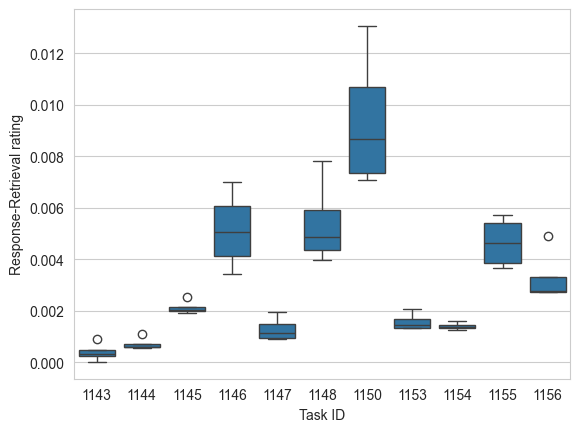

In [29]:
sdf32 = df3[['Response ID', 'Task ID', 'Response-Retrieval rating']].groupby(['Response ID', 'Task ID']).var()
sns.boxplot(x='Task ID', y='Response-Retrieval rating', data=sdf32)

<Axes: xlabel='Uzdevums', ylabel='Atbildes-Izgūtā uzdevuma līdzība'>

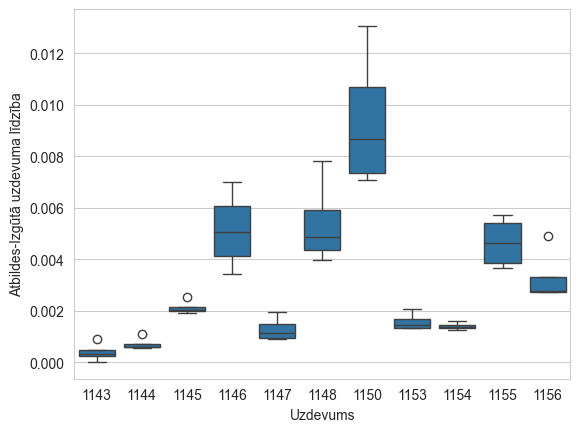

In [32]:
## Noise (Variance)


sdf52 = df5[['Atbilde', 'Uzdevums', 'Atbildes-Izgūtā uzdevuma līdzība' ,'Izgūto uzdevumu skaits']].groupby(['Atbilde', 'Uzdevums']).var()
sns.boxplot(x='Uzdevums', y='Atbildes-Izgūtā uzdevuma līdzība', data=sdf52)

<Axes: xlabel='Izgūto uzdevumu skaits', ylabel='Atbildes-Izgūtā uzdevuma līdzība'>

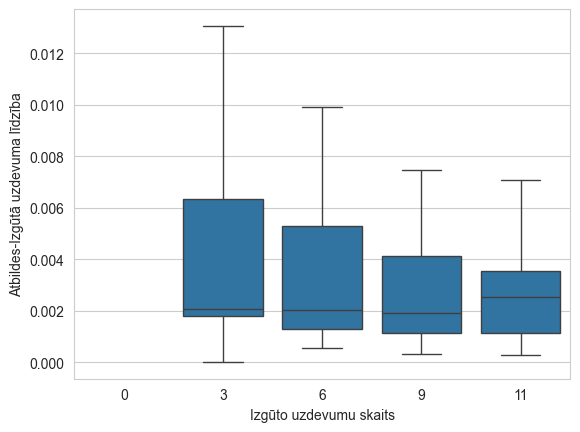

In [34]:
sdf52 = df5[['Atbilde', 'Uzdevums', 'Atbildes-Izgūtā uzdevuma līdzība' ,'Izgūto uzdevumu skaits']].groupby(['Atbilde', 'Uzdevums', 'Izgūto uzdevumu skaits']).var()
sns.boxplot(x='Izgūto uzdevumu skaits', y='Atbildes-Izgūtā uzdevuma līdzība', data=sdf52)

## Economic metrics



<Axes: xlabel='Task ID', ylabel='Coverage per token'>

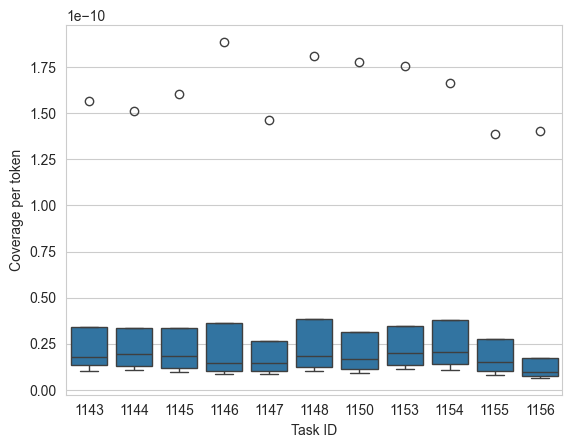

In [13]:
sdf31['Coverage per token'] = sdf31['Response-Retrieval rating']/sdf31['Input token count'] * input_token_cost
sns.boxplot(x='Task ID', y='Coverage per token', data=sdf31)
#print(sdf31)

<Axes: xlabel='Retrieved task count', ylabel='Coverage per token'>

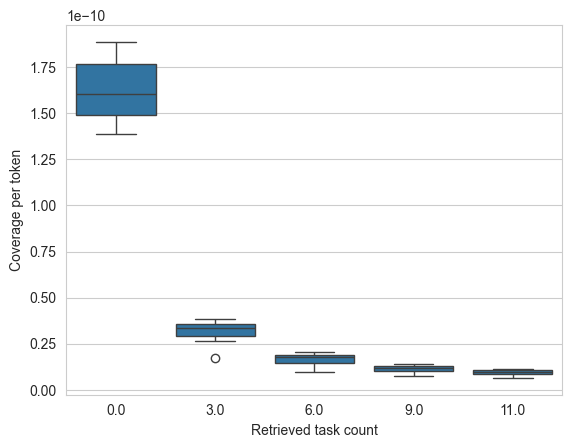

In [14]:
sns.boxplot(x='Retrieved task count', y='Coverage per token', data=sdf31)

<Axes: xlabel='Task ID', ylabel='Coverage per token'>

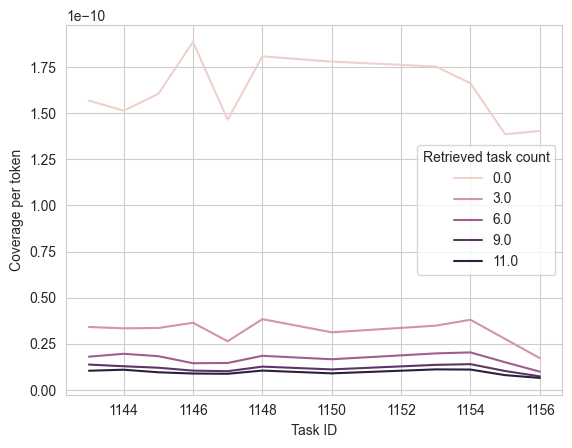

In [15]:
sns.lineplot(x='Task ID', y='Coverage per token', hue='Retrieved task count', data=sdf31)

# Case studies

Tasks 1148, 1150, 1155 and 1156 exhibit deviation from other tasks which could indicate that the most relevant tasks determined by cosine similarity was deemed irrelevant by large language model.


### Task 1148
| Type         | Title                      | Description                                                                    |
|--------------|----------------------------|--------------------------------------------------------------------------------|
| Miscellanous | Tenant meeting. Zilupes 8. | Prepare agenda for the meeting about reconstruction of the house on Zilupes 8. |

<Axes: xlabel='Response ID', ylabel='Retrieved task ID'>

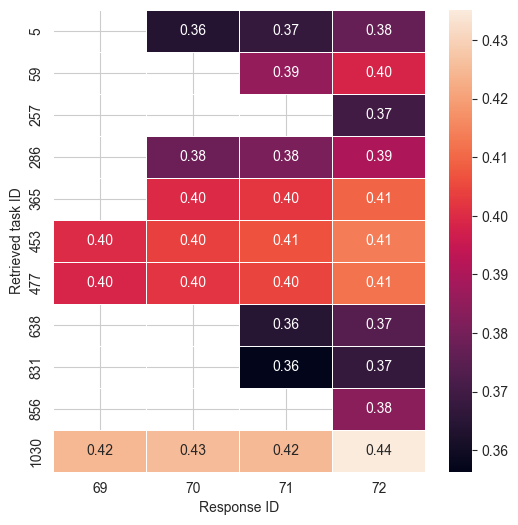

In [16]:
task1148df = df3[(df3['Task ID'] == 1148) & (df3['Retrieved task ID']!= 1148)][['Response ID', 'Retrieved task ID', 'Response-Retrieval rating']]
task1148df_pivot = task1148df.pivot(index='Retrieved task ID', columns='Response ID', values='Response-Retrieval rating')

f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(task1148df_pivot, annot=True, fmt=".2f", linewidths=.5)

<Axes: xlabel='Response ID', ylabel='Retrieved task ID'>

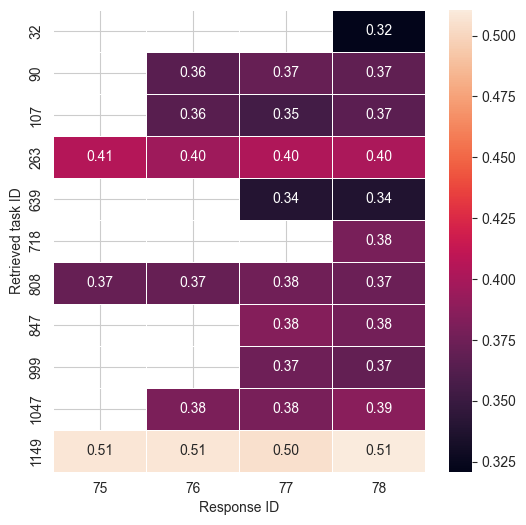

In [17]:
task1150df = df3[(df3['Task ID'] == 1150) & (df3['Retrieved task ID']!= 1150)][['Response ID', 'Retrieved task ID', 'Response-Retrieval rating']]
task1150df_pivot = task1150df.pivot(index='Retrieved task ID', columns='Response ID', values='Response-Retrieval rating')

f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(task1150df_pivot, annot=True, fmt=".2f", linewidths=.5)


([<matplotlib.patches.Wedge at 0x1a9f0ac0830>,
 [Text(0.8652391459142186, 0.6792357619984639, 'Landscaping'),
  Text(-0.8766079302885434, 0.6644987107250369, 'Building maintenance'),
  Text(-0.6520722620667432, -0.885890379811837, 'Graveyard'),
  Text(0.21269774216878434, -1.0792403210019081, 'Miscellaneous'),
  Text(0.973113119302458, -0.5128848379913764, 'Construction')],
 [Text(0.47194862504411916, 0.3704922338173439, '21.2%'),
  Text(-0.4781497801573873, 0.3624538422136564, '37.0%'),
  Text(-0.3556757793091326, -0.4832129344428201, '13.5%'),
  Text(0.11601695027388234, -0.5886765387283134, '12.9%'),
  Text(0.5307889741649771, -0.2797553661771144, '15.4%')])

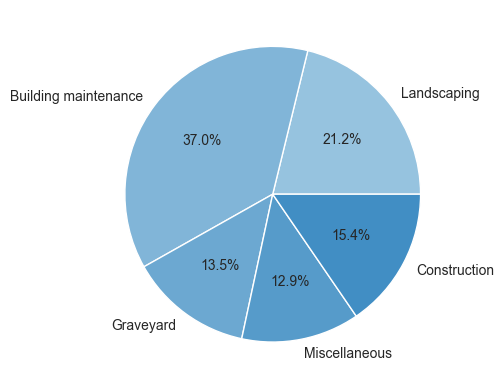

In [42]:
cursor.execute("select name, task_count from tasker.task_distributions_by_type")
columns4 = ['Uzdevuma veids', 'Skaits']
palette_color = sns.color_palette("Blues_d", 10)
df4 = pd.DataFrame(cursor.fetchall(), columns=columns4)
plt.pie(df4['Skaits'], labels=df4['Uzdevuma veids'], autopct='%1.1f%%', colors=palette_color)